# Correlation Study

25/10/04 13:09:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/04 13:09:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


--- Starting Correlation Study for: datamart/silver/fe_financials/silver_features_financials ---
Successfully loaded 473 records.

--- Capping outliers for 'Annual_Income' at the 95.0th percentile ---
Values in 'Annual_Income' above 127559.68 will be capped.

--- Capping outliers for 'Monthly_Inhand_Salary' at the 95.0th percentile ---
Values in 'Monthly_Inhand_Salary' above 10205.19 will be capped.

--- Capping outliers for 'Outstanding_Debt' at the 95.0th percentile ---
Values in 'Outstanding_Debt' above 3791.41 will be capped.

--- Calculating Pearson Correlation Matrix (after capping outliers) ---
Correlation Matrix:
                        Annual_Income  Monthly_Inhand_Salary  \
Annual_Income                    1.00                   0.96   
Monthly_Inhand_Salary            0.96                   1.00   
Delay_from_due_date             -0.24                  -0.23   
Num_of_Delayed_Payment          -0.05                  -0.04   
Outstanding_Debt                -0.26              

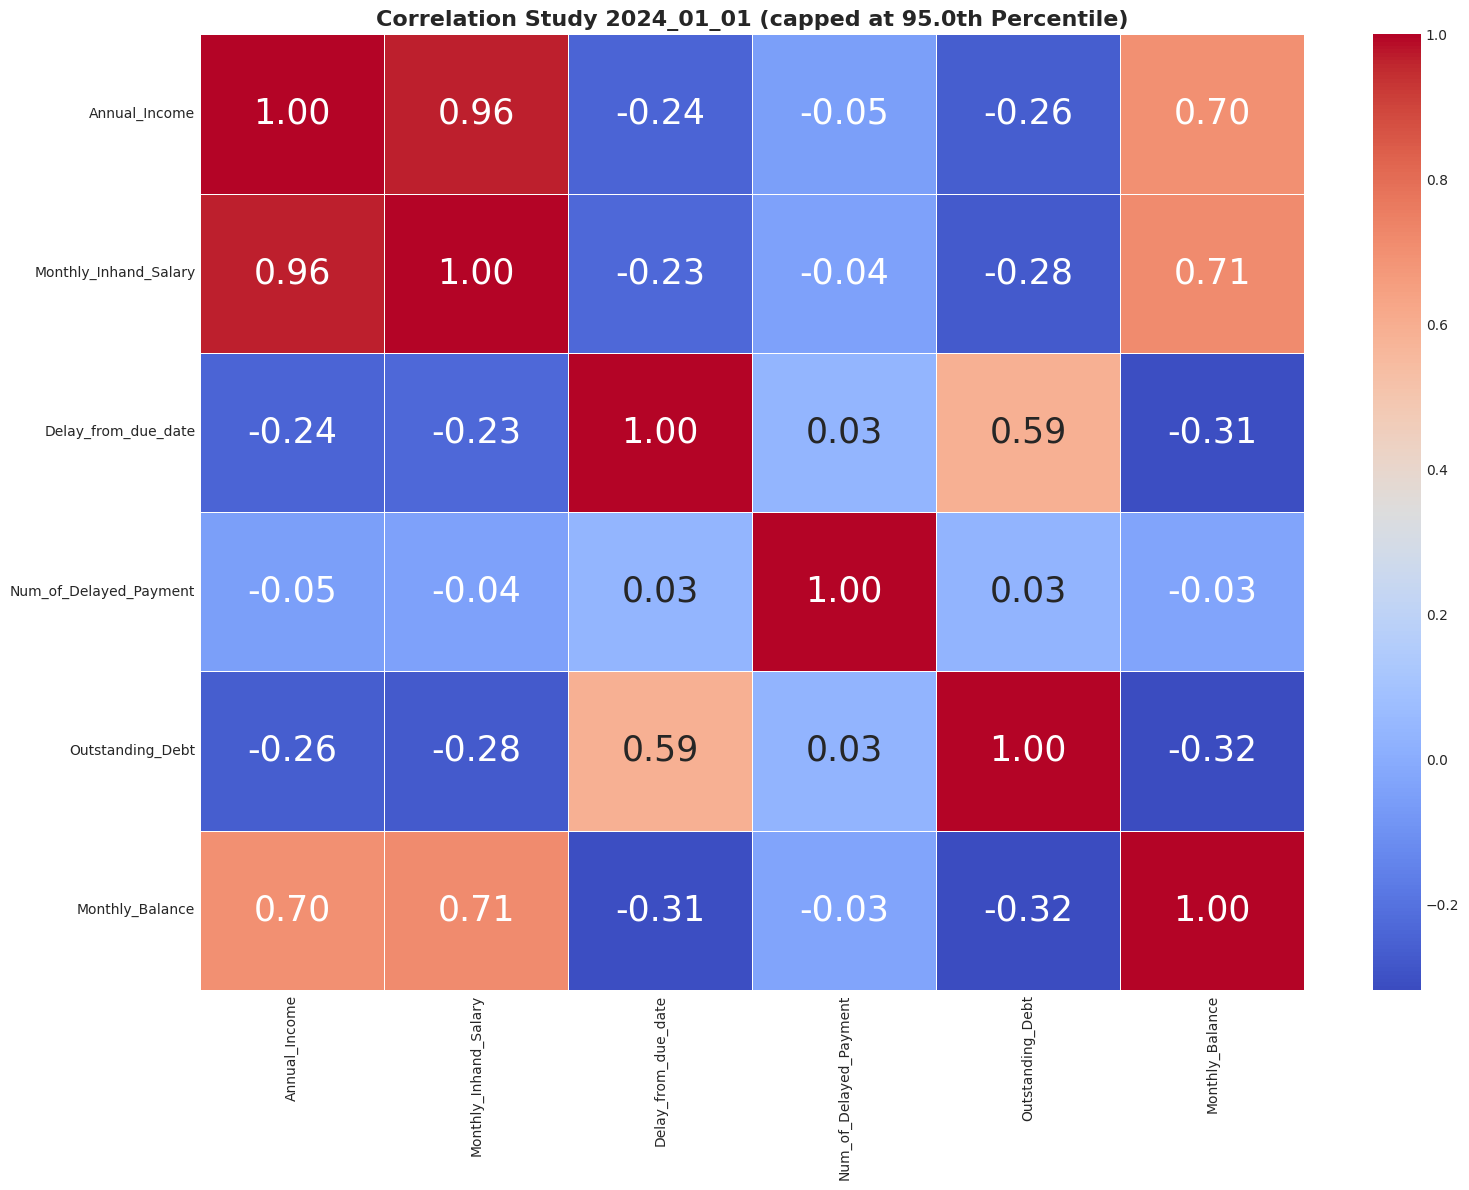

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def _cap_outliers(df, column_name, percentile=0.995):
    print(f"\n--- Capping outliers for '{column_name}' at the {percentile*100}th percentile ---")
    # Calculate the percentile value to use as the cap
    cap_value = df.approxQuantile(column_name, [percentile], 0.01)[0]
    
    if cap_value is not None:
        print(f"Values in '{column_name}' above {cap_value:.2f} will be capped.")
        # Create a new column with the capped values
        df_capped = df.withColumn(
            column_name,
            when(col(column_name) > cap_value, lit(cap_value))
            .otherwise(col(column_name))
        )
        return df_capped
    else:
        print(f"Could not calculate cap value for '{column_name}'. Skipping.")
        return df

def perform_correlation_study(spark, filepath, snapshot, numerical_cols):
    print(f"--- Starting Correlation Study for: {filepath} ---")

    # [1] Load and Prepare Data
    try:
        df = spark.read.parquet(filepath+"_"+snapshot+".parquet", header=True)

        print(f"Successfully loaded {df.count()} records.")
    except Exception as e:
        print(f"ERROR: Failed to load the file. Details: {e}")
        return

    # Cap outliers before correlation analysis
    percentile = 0.95
    df = _cap_outliers(df, "Annual_Income", percentile)
    df = _cap_outliers(df, "Monthly_Inhand_Salary", percentile)
    df = _cap_outliers(df, "Outstanding_Debt", percentile)
    
    df_numeric = df.select(numerical_cols).na.drop() # Drop rows with nulls for accurate correlation

    # [2] Assemble features into a single vector column
    assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
    df_vector = assembler.transform(df_numeric).select("features")

    # [3] Calculate the Pearson correlation matrix
    print("\n--- Calculating Pearson Correlation Matrix (after capping outliers) ---")
    matrix = Correlation.corr(df_vector, "features").head()
    corr_matrix = matrix[0].toArray()

    # Convert the matrix to a pandas DataFrame for better readability and plotting
    corr_df = pd.DataFrame(corr_matrix, index=numerical_cols, columns=numerical_cols)
    
    print("Correlation Matrix:")
    print(corr_df.round(2))

    # [4] Visualize the Correlation Matrix as a Heatmap
    print("\n--- Generating Correlation Heatmap ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 12))
    
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax,annot_kws ={"size":25})
    
    ax.set_title(f"Correlation Study {snapshot} (capped at {percentile*100}th Percentile)", fontsize=16, fontweight='bold')
    plt.xticks(fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()


spark = SparkSession.builder.appName("CorrelationStudy").getOrCreate()

FILE_PATH = "datamart/silver/fe_financials/silver_features_financials"
# snapshots = ['*','2023_01_01','2023_07_01','2024_01_01','2024_07_01','2025_01_01']
# snapshots = ['*','2024_01_01']
snapshots = ['2024_01_01']
# Select only the key numerical columns for the correlation analysis.
numerical_cols = [
    "Annual_Income", "Monthly_Inhand_Salary", 
    # "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", 
    "Delay_from_due_date", "Num_of_Delayed_Payment", 
    # "Changed_Credit_Limit", "Num_Credit_Inquiries","Credit_Utilization_Ratio", 
    "Outstanding_Debt", 
    # "Amount_invested_monthly",
    # "Total_EMI_per_month",
    "Monthly_Balance"
]
for snapshot in snapshots:
    perform_correlation_study(spark, FILE_PATH, snapshot, numerical_cols)

spark.stop()